In [356]:
import argparse
import os
import random
import time
import math

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim

# machine learning
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

# data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

In [357]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [358]:
import socket
myHostName = socket.gethostname()
print(myHostName)

Tarins-MacBook


In [359]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of feature maps in discriminator
ndf = 64

# number of signals per iteration
batch_size = 32

# Number of training epochs
num_epochs = 500

# learning rate
lr = 0.001

prediction_type = "classification"

parameter = 'beta1_IC_b'

### Dataloader

In [360]:
class GWDataset(Dataset):
    def __init__(self, x, y):
        self.parameters = y

        x = np.transpose(x)
        self.data = x

        ### signal cutting section ###
        
        temp_data = np.empty(shape = (256, 0)).astype('float32')

        for i in range(0, self.data.shape[1]):
            signal = self.data[:, i]
            signal = signal.reshape(1, -1)

            # cut signal down to last 256 samples
            signal = signal[:, int(len(signal[0]) - 256):len(signal[0])]

            temp_data = np.insert(temp_data, temp_data.shape[1], signal, axis=1)            

        self.data = temp_data
        ### end signal augmentation section ###

    def calc_stats(self):
        self.mean = self.data.mean()
        print('Dataset mean: ',  self.mean)
        self.std = np.std(self.data, axis=None)
        print('Dataset std: ',  self.std)

        self.parameter_mean = self.parameters.mean()
        print('Parameter mean: ',  self.parameter_mean)
        self.parameter_std = np.std(self.parameters, axis=None)
        print('Parameter std: ',  self.parameter_std)

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal
    
    def standardize_signal(self, signal):
        standardized_signal = (signal - self.mean) / self.std
        standardized_signal = standardized_signal / self.scaling_factor
        return standardized_signal
    
    def standardize_parameter(self, parameter):
        standardized_parameter = (parameter - self.parameter_mean) / self.parameter_std
        return standardized_parameter

    ### overloads ###
    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        parameter = self.parameters[idx,:]
        parameter = parameter.reshape(1, -1)

        # signal_standardized = self.standardize(signal)
        # parameter_standardized = self.standardize_parameter(parameter)

        return signal, parameter

In [361]:
x = pd.read_csv("../data/richers_1764.csv")
y = pd.read_csv("../data/richers_1764_parameters.csv")

# remove erroneous signals and select only beta_IC_b as label
keep_signals_idx = np.array(y[y['beta1_IC_b'] > 0].index)
y = y.iloc[keep_signals_idx,:]
y = y[parameter]

# bin labels to get discretised beta1_IC_b based on Richers et al. 2017
if (parameter == 'beta1_IC_b'):  
    ranges = [0, 0.06, 0.17, 1]
    labels = [0, 1, 2]
    num_classes = len(labels)
    y = pd.cut(y, bins=ranges, labels=labels).astype('int')
    y = y.values
    # num_bins = 3
    # dummy, bin_boundaries = pd.qcut(y, q=num_bins, retbins=True, duplicates='drop')
    # print(bin_boundaries)
    # y = y.values
    # y = np.digitize(y,bins=bin_boundaries[1:num_bins])
    # print(y)
    # unique_ye_c_b= np.unique(y)
    # num_classes = len(unique_ye_c_b)
elif (parameter == 'A(km)'):
    num_classes = 5
    replacement_dict = {300: 0, 467: 1, 634: 2, 1268: 3, 10000: 4}
    y = y.replace(replacement_dict)
    y = y.values
elif (parameter == 'omega_0(rad|s)'):
    # Bin the 'parameter' column into equal frequency bins and save the bin boundaries
    unique_omega_0 = y.unique()
    num_classes = len(unique_omega_0)
    y = ((y / 0.5) - 1).astype('int')
    y = y.values
elif (parameter == 'Ye_c_b'):
    num_bins = 5
    dummy, bin_boundaries = pd.qcut(y, q=num_bins, retbins=True, duplicates='drop')
    y = y.values
    y = np.digitize(y,bins=bin_boundaries[1:num_bins])
    print(y)
    unique_ye_c_b= np.unique(y)
    num_classes = len(unique_ye_c_b)

print(y)

y = np.eye(num_classes)[y]

print(y)

# drop corresponding signals which have erroneous parameter values
x = x.iloc[:,keep_signals_idx]
x = x.values.astype('float32')

# only transpore x due to compatibility issues with train_test_split
x = np.transpose(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=manualSeed)

train_data = GWDataset(x_train, y_train)
test_data = GWDataset(x_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

[0.0003535  0.02911056 0.10210584 0.21547661]
[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


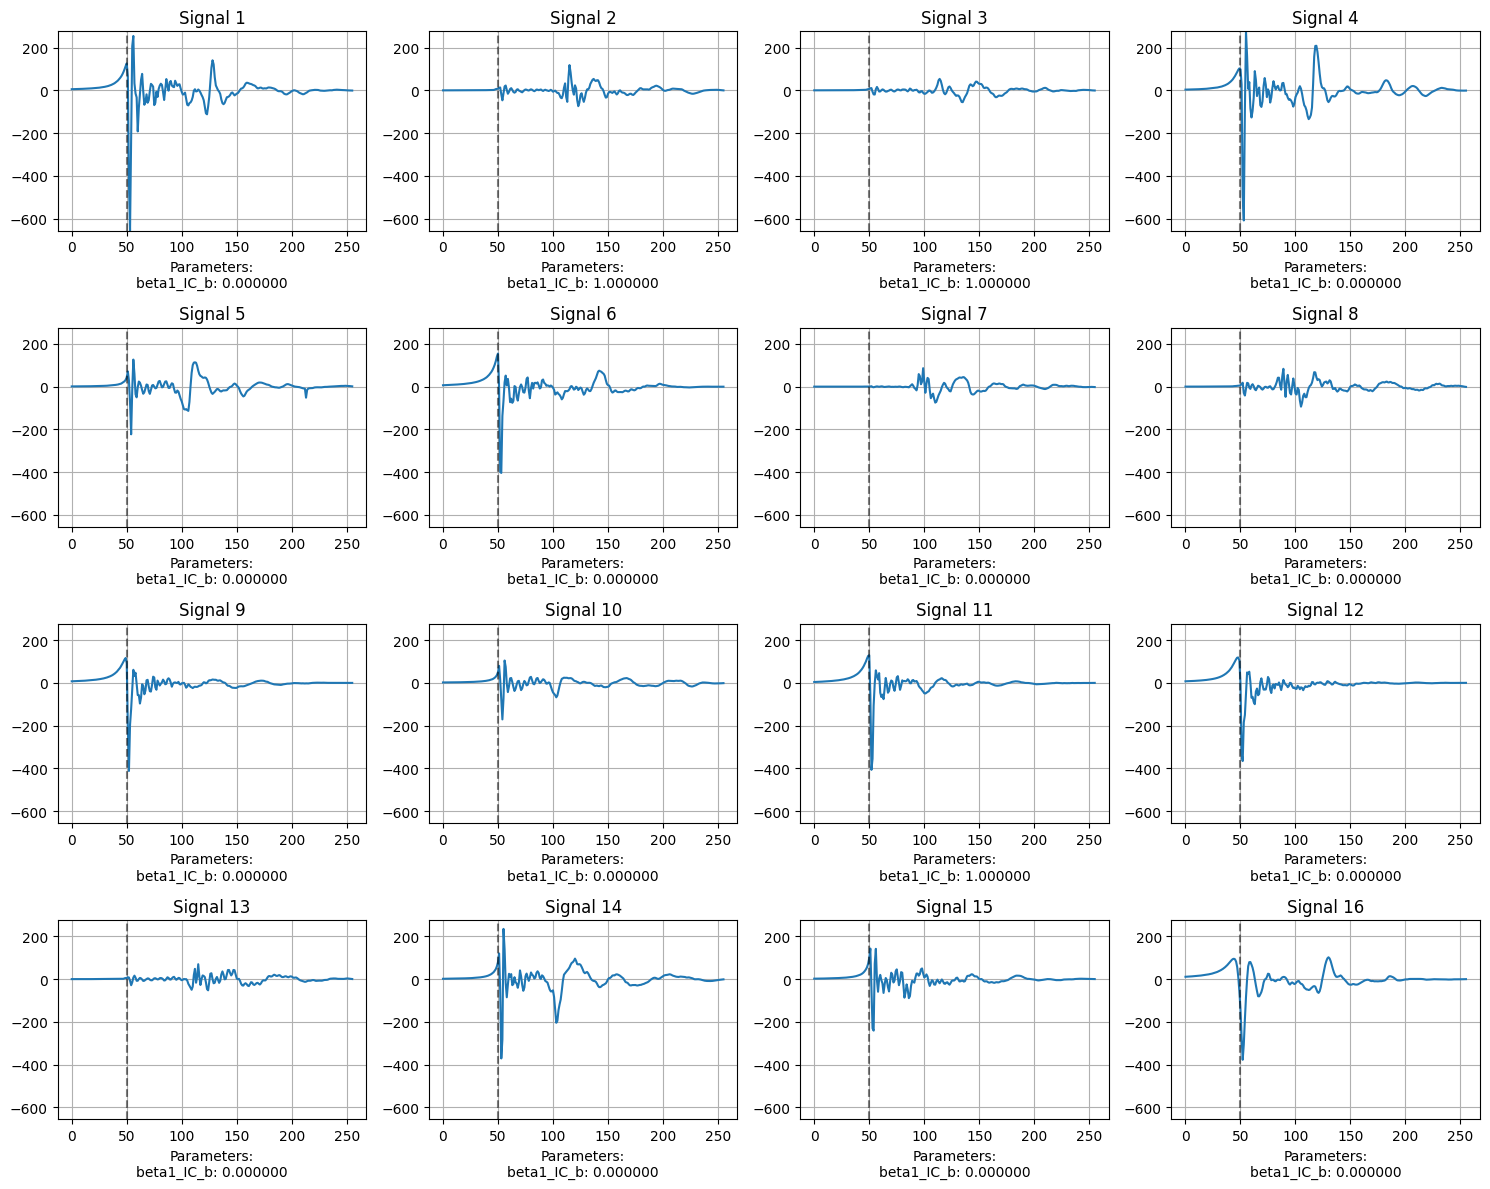

In [362]:
real_signals_batch, real_parameter_batch  = next(iter(train_loader))

common_ylim = (real_signals_batch[:,:,:].min(), real_signals_batch[:,:,:].max())
parameter_names = [parameter]

def plot_waveforms(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        ax.plot(x, y)

        ax.axvline(x=50, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i + 1}')
        ax.grid(True)
        ax.set_ylim(common_ylim)

        # Get parameter values as a NumPy array
        parameters = real_parameter_batch[i, :].numpy()[0]

        # Combine parameter names and values, format as a string
        parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}'
        ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(512, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()

    plt.show()
    
plot_waveforms(real_signals_batch, real_parameter_batch)

### Weight Initialisation

In [363]:
# custom weights initialization called on classifier
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Classifier Network

In [364]:
class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=16, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=8, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 8),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                #         stride=2, padding=0, bias=False),
                # nn.BatchNorm1d(ndf * 16),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 32),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 64),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),
                
                # nn.Conv1d(ndf * 64, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False)
            )

            self.fc_reg = nn.Sequential(
                nn.LazyLinear(1),
            )

            self.fc_class = nn.Sequential(
                nn.LazyLinear(num_classes),
                nn.Softmax(dim=1),
            )

        def forward(self, x):
            x = self.main(x)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            if (prediction_type == "regression"):
                x = self.fc_reg(x)
            else:
                x = self.fc_class(x)
            return x

In [365]:
net = Discriminator().to(device)
net.apply(weights_init)

print(net)

model = Discriminator()
summary(model, input_size=(1, 256))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(16,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(8,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout1d(p=0.2, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout1d(p=0.2, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout1d(p=0.2

/Users/tarineccleston/Documents/software-ds/gw-parameter-estimation/.venv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Loss functions and Optimisers

In [366]:
if (prediction_type == "regression"):
    criterion = nn.MSELoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

### Training

In [367]:
C_gradients = []
C_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.float32)
        labels = labels.squeeze(1)

        # print(inputs)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # save losses and gradients for plotting later
        # C_gradients.append([param.grad.norm().item() for param in net.parameters()])
        C_losses.append(loss.item())
        running_loss += loss.item()

    print("Epoch: "f'{epoch + 1} loss: {running_loss:.3f}')
    running_loss = 0.0

print('Finished Training')

Epoch: 1 loss: 47.423
Epoch: 2 loss: 47.472
Epoch: 3 loss: 47.311


KeyboardInterrupt: 

### Gradients

Maybe visualise this later. Not sure what's going on. 

In [ ]:
# # get the total number of layers in the classifier
# C_gradients = np.array(C_gradients)
# num_layers = C_gradients.shape[1]

# # Plot the gradients over training epochs
# plt.figure(figsize=(10, 6))
# for i in range(num_layers):
#     # Calculate alpha value based on layer index
#     alpha = 1 - (i / num_layers)  # Higher layers are more transparent
#     plt.plot(C_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

# plt.xlabel('iterations')
# plt.ylabel('Gradient Magnitude')
# plt.title('Classifier Gradients')
# plt.legend()
# plt.show()

### Loss

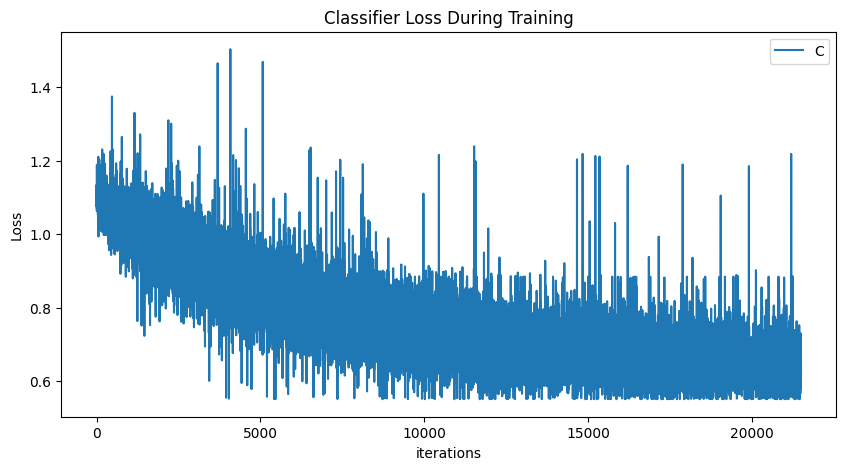

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Classifier Loss During Training")
plt.plot(C_losses,label="C")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Testing

In [ ]:
confusion_mtx = torch.zeros(num_classes, num_classes)

cum_true_indices = torch.Tensor().to(device, dtype=torch.float32)
cum_predicted_indices = torch.Tensor().to(device, dtype=torch.float32)

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.long)  # Use torch.long for class indices
        labels = labels.squeeze(1)

        outputs = net(inputs)

        true_indices = torch.argmax(labels, dim=1)
        predicted_indices = torch.argmax(outputs, dim=1)

        cum_true_indices = torch.concat([cum_true_indices, true_indices], axis=0)
        cum_predicted_indices = torch.concat([cum_predicted_indices, predicted_indices], axis=0)

        # Update the confusion matrix
        # batch_confusion_mtx = confusion_matrix(true_indices.cpu(), predicted_indices.cpu(), labels=range(num_classes))


### Confusion Matrix

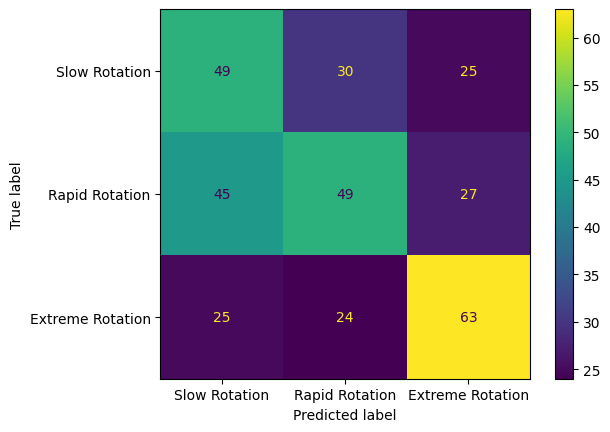

In [ ]:
if (parameter == 'beta1_IC_b'):
    display_labels = ["Slow Rotation", "Rapid Rotation", "Extreme Rotation"]
elif (parameter == 'A(km)'):
    display_labels = [300, 467, 634, 1268, 10000]
else:
    display_labels = []

confusion_matrix = metrics.confusion_matrix(cum_true_indices.cpu(), cum_predicted_indices.cpu())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = display_labels)

cm_display.plot()
plt.show()

beta-IC-b of the inner core at bounce: Slow Rotation (beta-IC-b < 0.06), Rapid Rotation (0.06 < beta-IC-b < 0.17), and Extreme Rotation (beta-IC-b > 0.17)